In [1]:
import py0
import maxent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


## Set-up Initial Guesses

In [2]:
M = 3
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.52595471, 0.28709197, 0.18695332],
        [0.28194211, 0.28400909, 0.4340488 ],
        [0.14275661, 0.40926313, 0.44798026]]),
 array([1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 0)
tmat.add_transition('A', 'I', 3, 0)
tmat.add_transition('I', 'R', 14, 0)
tmat.value

array([[0.8       , 0.2       , 0.        , 0.        ],
       [0.        , 0.66666667, 0.33333333, 0.        ],
       [0.        , 0.        , 0.92857143, 0.07142857],
       [0.        , 0.        , 0.        , 1.        ]])

In [4]:
start = np.zeros((M, C))
start[0, 1] = 0.1
beta = np.array([0.2, 0.2])
infect = py0.ContactInfectionLayer(beta, [1,2])

## Build Metapopulation Keras Model

In [21]:
model = py0.TrainableMetaModel(start, R, tmat.value, infect, 150, lambda traj: (traj[:, 100, 0, 3] - 0.3)**2)

In [22]:
model.compile(optimizer=tf.keras.optimizers.RMSprop())
utraj = model.get_traj()
model.fit()

100/100 [==============================] - 7s 45ms/step - loss: 0.0218 - output_2_loss: 0.0218


In [23]:
traj.shape

TensorShape([1, 150, 3, 5])

In [24]:
model.summary()

Model: "trainable_meta_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 trainable_input_layer_12 (T  multiple                 9         
 rainableInputLayer)                                             
                                                                 
 trainable_input_layer_13 (T  multiple                 16        
 rainableInputLayer)                                             
                                                                 
 trainable_input_layer_14 (T  multiple                 12        
 rainableInputLayer)                                             
                                                                 
 metapop_layer_4 (MetapopLay  multiple                 2         
 er)                                                             
                                                                 
 traj (AddSusceptibleLayer)  multiple       

## Plot agreement with constraint

We only set agreement at `T = 100`

In [25]:
traj = model.get_traj()

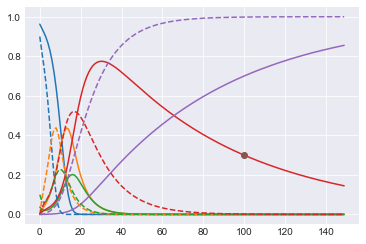

In [26]:
plt.plot(traj[0, :, 0, :])
plt.gca().set_prop_cycle(None)
plt.plot(utraj[0, :, 0, :], linestyle='--')
plt.plot(100, 0.3, 'o')